In [9]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import community as community_louvain
from sklearn.cluster import SpectralClustering
from networkx.algorithms.community import modularity
from sklearn.preprocessing import StandardScaler
import numpy as np

%matplotlib inline

### Reading data

In [32]:
# Load the preprocessed data
preprocessed_df = pd.read_csv('players_20.csv')

# Taking only 1000 entries for the sake of computation
preprocessed_df = preprocessed_df.iloc[:1000]

# Columns to use
attributes_df = preprocessed_df[['short_name', 'nationality', 'club']]

In [18]:
attributes_df

,short_name,nationality,club
0,L. Messi,Argentina,FC Barcelona
1,Cristiano Ronaldo,Portugal,Juventus
2,Neymar Jr,Brazil,Paris Saint-Germain
3,J. Oblak,Slovenia,Atlético Madrid
4,E. Hazard,Belgium,Real Madrid
...,...,...,...
4995,Y. Bodiger,France,Cádiz CF
4996,A. Micai,Italy,US Salernitana 1919
4997,I. Provedel,Italy,Empoli
4998,N. Haas,Switzerland,Frosinone


In [19]:
# Compute cosine similarity matrix for the attributes
#similarity_matrix = cosine_similarity(attributes_df)

### Setting up graph

In [33]:
# Create a new nationality graph
G = nx.Graph()

# Add nodes with player names as identifiers
for idx, row in preprocessed_df.iterrows():
    G.add_node(row['short_name'], nationality=row['nationality'], club=row['club'])


# Add edges between players that share the same
for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        # Avoid self-loops and duplicate edges by checking only if node1 < node2
        if node1 < node2:
            # Add edge if they share the same nationality or club
            if data1['nationality'] == data2['nationality']:
                G.add_edge(node1, node2)

/var/folders/q5/kv3lnx553934jm0hgvrsxwrr0000gn/T/ipykernel_23950/3838626076.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


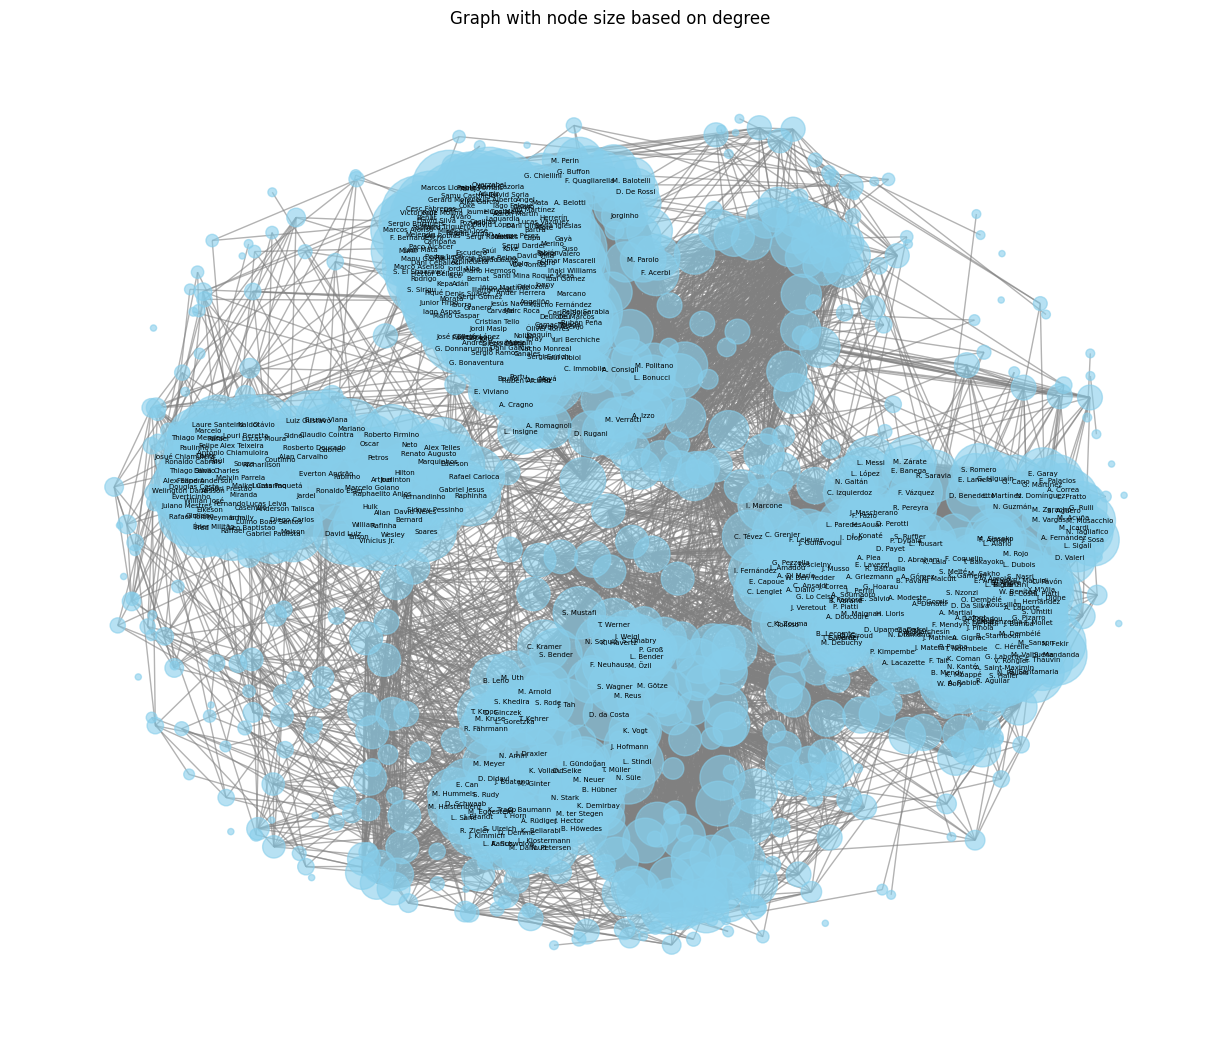

In [40]:
# Visualizing the entire graph

# Define a layout with increased spacing
pos = nx.spring_layout(G, seed=42, k=0.6)  # Adjust `k` to spread nodes apart more

# Calculate node sizes based on degree (for undirected graph, degree is total connections)
node_sizes = [20 + 20 * G.degree(n) for n in G.nodes()]  # Increase scaling factor for visibility

# Identify the top 100 nodes with the greatest degree
top_100_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:500]
top_100_labels = {node: node for node, _ in top_100_nodes}  # Dictionary for labels of top nodes
top_100_degrees = [degree for _, degree in top_100_nodes]  # Extract degrees for coloring

# Create a color map for the top 100 nodes based on their degree
cmap = plt.cm.get_cmap('viridis')
if max(top_100_degrees) == min(top_100_degrees):
    # If all degrees are the same, assign a single color
    top_100_colors = [cmap(0.5) for _ in top_100_degrees]
else:
    # Otherwise, use a color gradient based on degree
    top_100_colors = [cmap((degree - min(top_100_degrees)) / (max(top_100_degrees) - min(top_100_degrees))) for degree in top_100_degrees]

# Plot the graph
plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos,
    with_labels=False,  # Disable all labels initially
    node_size=node_sizes,  # Adjust node size based on degree
    node_color="skyblue",  # Assign color based on top 100 degree or default color
    edge_color="gray",
    alpha=0.6  # Set higher transparency for nodes
)

# Add labels only for the top 100 nodes
nx.draw_networkx_labels(G, pos, labels=top_100_labels, font_size=5, font_color="black")

plt.title("Graph with node size based on degree")
plt.axis("off")
plt.show()

### Clustering coefficient / locality property

In [63]:
clustering_coeff = nx.clustering(G)
for node, coeff in clustering_coeff.items():
    print(f"Node: {node}, Clustering Coefficient: {coeff}")

Node: L. Messi, Clustering Coefficient: 1.0
Node: Cristiano Ronaldo, Clustering Coefficient: 1.0
Node: Neymar Jr, Clustering Coefficient: 1.0
Node: J. Oblak, Clustering Coefficient: 1.0
Node: E. Hazard, Clustering Coefficient: 1.0
Node: K. De Bruyne, Clustering Coefficient: 1.0
Node: M. ter Stegen, Clustering Coefficient: 1.0
Node: V. van Dijk, Clustering Coefficient: 1.0
Node: L. Modrić, Clustering Coefficient: 1.0
Node: K. Mbappé, Clustering Coefficient: 1.0
Node: K. Koulibaly, Clustering Coefficient: 1.0
Node: H. Kane, Clustering Coefficient: 1.0
Node: Alisson, Clustering Coefficient: 1.0
Node: De Gea, Clustering Coefficient: 1.0
Node: N. Kanté, Clustering Coefficient: 1.0
Node: G. Chiellini, Clustering Coefficient: 1.0
Node: S. Agüero, Clustering Coefficient: 1.0
Node: Sergio Ramos, Clustering Coefficient: 1.0
Node: L. Suárez, Clustering Coefficient: 1.0
Node: R. Lewandowski, Clustering Coefficient: 1.0
Node: Sergio Busquets, Clustering Coefficient: 1.0
Node: A. Griezmann, Clusteri

A clustering coefficient of 1 indicates a strong local community structure around that node. The node is in a "perfect clique" with its neighbors, meaning they all know each other in the context of a social network.

In [64]:
average_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {average_clustering}")

Average Clustering Coefficient: 0.971252566735113


It indicates that the graph is composed of tightly connected communities or is itself a fully connected network.

### Louvain communities

In [41]:
# Apply the Louvain algorithm to detect communities
partition = community_louvain.best_partition(G)

/var/folders/q5/kv3lnx553934jm0hgvrsxwrr0000gn/T/ipykernel_23950/4154264793.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_communities))


Number of communities: 77


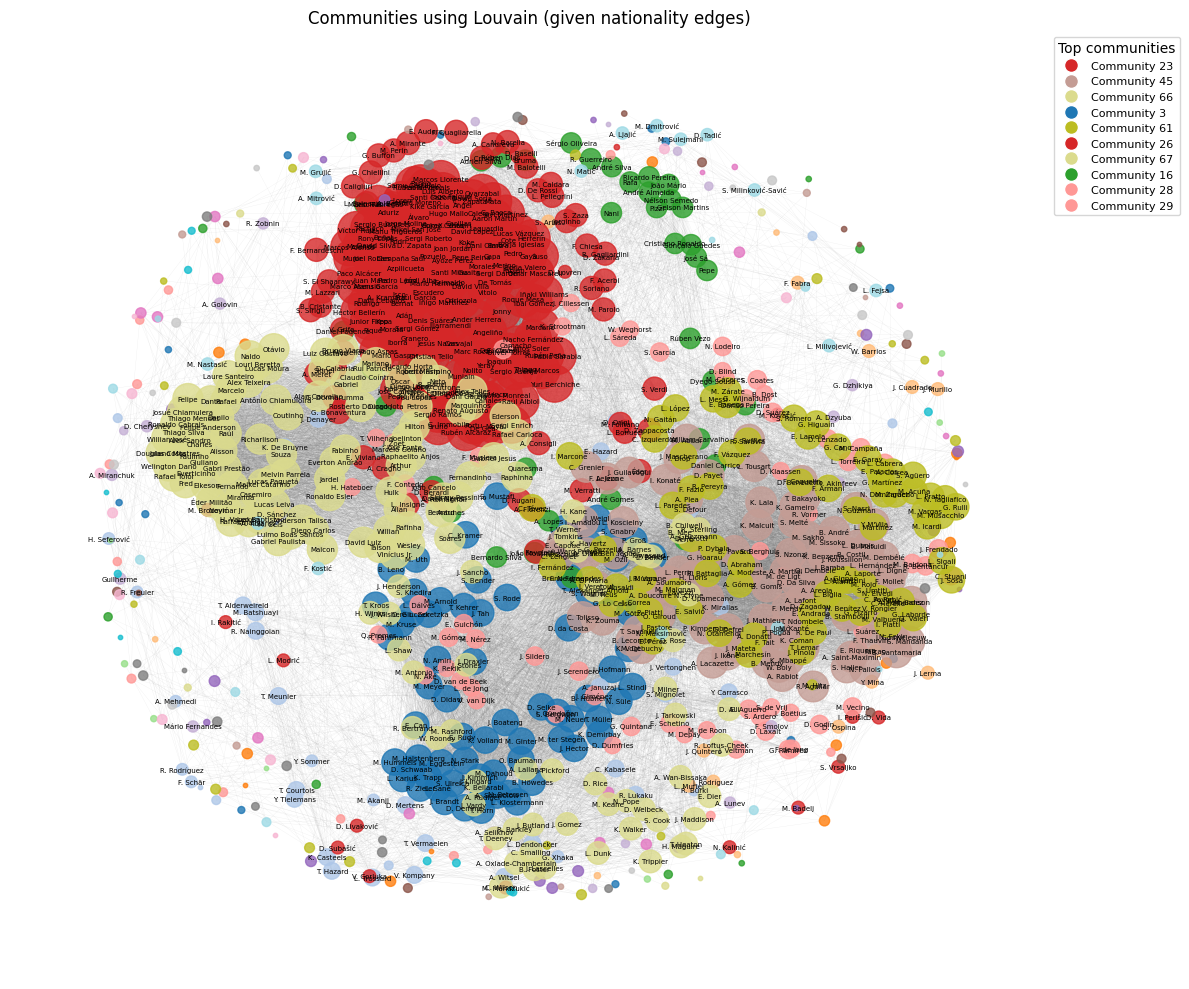

In [50]:
# Making a prettier plot :)
pos = nx.spring_layout(G, seed=42, k=0.8)  # Adjust `k` as needed

# Generate a color map for the communities
unique_communities = set(partition.values())
color_map = plt.cm.get_cmap('tab20', len(unique_communities)) 

print('Number of communities:', len(unique_communities))

# Calculate dynamic node sizes based on their degree 
node_sizes = {n: 10 + 5 * G.degree(n) for n in G.nodes()}

# Get community sizes and sort communities by size
community_sizes = {community_id: sum(1 for node in partition if partition[node] == community_id)
                   for community_id in unique_communities}
top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:10]  

# Draw nodes with colors based on their community
plt.figure(figsize=(12, 10))
for community_id in unique_communities:
    members = [node for node in partition if partition[node] == community_id]
    community_sizes = [node_sizes[node] for node in members]  # Get sizes for community members
    
    nx.draw_networkx_nodes(
        G, pos, nodelist=members, node_size=community_sizes,
        node_color=[color_map(community_id)], alpha=0.8,  # Set alpha for better transparency
        label=f"Community {community_id}"
    )

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color="gray", width=0.2)

# Draw labels with smaller font size to avoid clutter
threshold = 10  
high_degree_nodes = {n: n for n, d in G.degree() if d > threshold}
nx.draw_networkx_labels(G, pos, labels=high_degree_nodes, font_size=5, font_color="black")

# Manually create a custom legend with only the top 5 communities
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(cid), markersize=10)
           for cid in top_communities]
labels = [f"Community {cid}" for cid in top_communities]

plt.legend(handles, labels, scatterpoints=1, loc="upper left", bbox_to_anchor=(1, 1), fontsize=8, title="Top communities")


plt.title("Communities using Louvain (given nationality edges)")
plt.axis("off")  
plt.tight_layout()
plt.show()

### Modularity of Louvain communities

In [51]:
# Calculating modularity
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = set()
    communities[community_id].add(node)

# Create a list of communities
community_list = list(communities.values())

# Calculate modularity
modularity = nx.algorithms.community.modularity(G, community_list)
print(f"Modularity of the Louvain communities: {modularity}")

Modularity of the Louvain communities: 0.8229771490019547


Since the modularity is above 0.3, the community structure is not well-defined.

### Spectral clustering

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/var/folders/q5/kv3lnx553934jm0hgvrsxwrr0000gn/T/ipykernel_23950/1979353234.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_clusters))


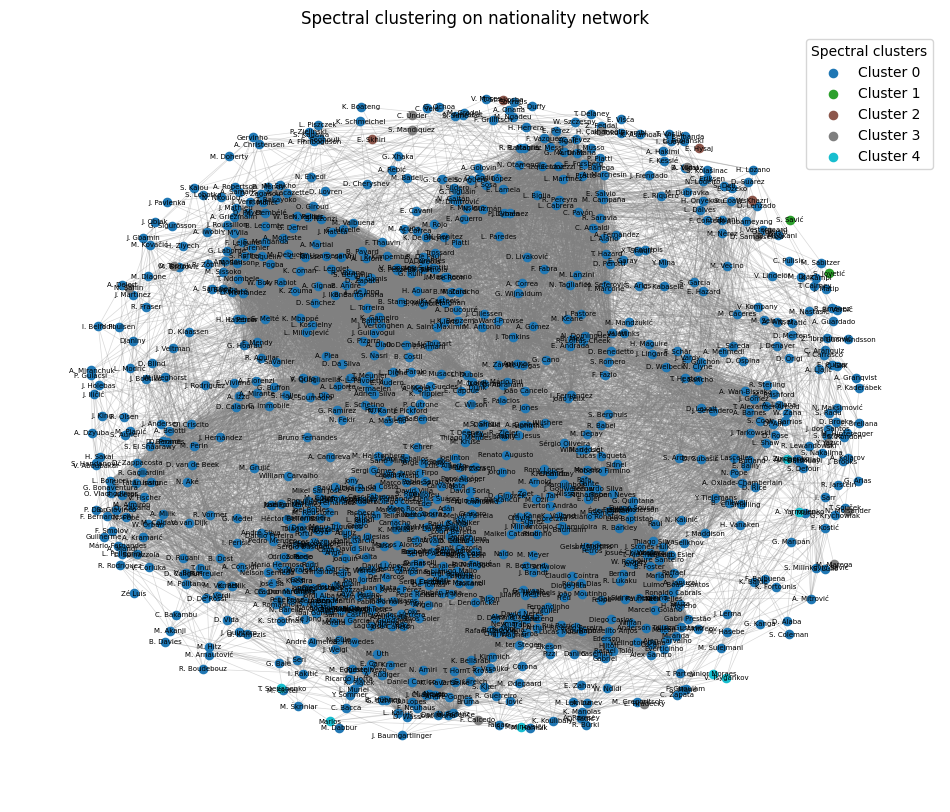

In [57]:
G.remove_nodes_from(list(nx.isolates(G)))

# Get the adjacency matrix of the graph
adj_matrix = nx.to_numpy_array(G)
adj_matrix = np.nan_to_num(adj_matrix, nan=0.0)

# Set the number of clusters
num_clusters = 5

# Perform spectral clustering on the adjacency matrix
spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
cluster_labels = spectral_model.fit_predict(adj_matrix)

# Assign clusters to nodes
for idx, node in enumerate(G.nodes()):
    G.nodes[node]['spectral_cluster'] = cluster_labels[idx]

# Visualize the clusters
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.8, seed=42)

# Assign colors based on cluster labels
unique_clusters = set(cluster_labels)
color_map = plt.cm.get_cmap('tab10', len(unique_clusters))

# Draw nodes by cluster
for cluster_id in unique_clusters:
    cluster_nodes = [node for node in G.nodes() if G.nodes[node]['spectral_cluster'] == cluster_id]
    nx.draw_networkx_nodes(
        G, pos, nodelist=cluster_nodes, node_size=35,
        node_color=[color_map(cluster_id)],
        label=f"Cluster {cluster_id}"
    )

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", width=0.5)

# Draw labels with smaller font size to avoid clutter
nx.draw_networkx_labels(G, pos, font_size=5, font_color="black")

# Display the legend and title
plt.legend(scatterpoints=1, loc="best", fontsize=10, title="Spectral clusters")
plt.title("Spectral clustering on nationality network")
plt.axis("off")
plt.show()